- competition/dataset : [https://www.kaggle.com/c/zillow-prize-1](https://www.kaggle.com/c/zillow-prize-1)
- date : 2021/03/01
- original : [https://www.kaggle.com/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity](https://www.kaggle.com/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity)

## Zillow EDA On Missing Values & Multicollinearity

**✏ 필사 1회** 

### The notebook covers Follwing Topics
```
- Missing Value Analysis  
- Correlation Analysis  
- Top Contributing Features (Through XGBoost)  
- Correlation Analysis  
- Multicollinearity Analysis  
- Univariate Analysis  
- Bivariate Analysis
```

### Global Imports

In [2]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import warnings
warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
%matplotlib inline

### Reading in Dataset

In [3]:
train = pd.read_csv('data/train_2016_v2.csv', parse_dates=['transactiondate'])
properties = pd.read_csv('data/properties_2016.csv')

### Shape of the Dataset

In [4]:
print('Shape of Train:', train.shape)
print('Shape of Properties:', properties.shape)

Shape of Train: (90275, 3)
Shape of Properties: (2985217, 58)


### Let's Merge Train and Properties to Facilitate EDA

In [5]:
merged = pd.merge(train, properties, on='parcelid', how='left')

### Fisrt Few Rows of Data

In [8]:
merged.head(3).T

,0,1,2
parcelid,11016594,14366692,12098116
logerror,0.0276,-0.1684,-0.004
transactiondate,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
airconditioningtypeid,1.0,NaN,1.0
architecturalstyletypeid,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN
bathroomcnt,2.0,3.5,3.0
bedroomcnt,3.0,4.0,2.0
buildingclasstypeid,NaN,NaN,NaN
buildingqualitytypeid,4.0,NaN,4.0


### Visualizing Datatype

In [19]:
dataTypeDf = pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={'index':'variableType', 0:'count'})
dataTypeDf

,variableType,count
0,float64,53
1,object,5
2,datetime64[ns],1
3,int64,1


[Text(0.5, 0, 'Variable Type'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Variables Count Across Datatype')]

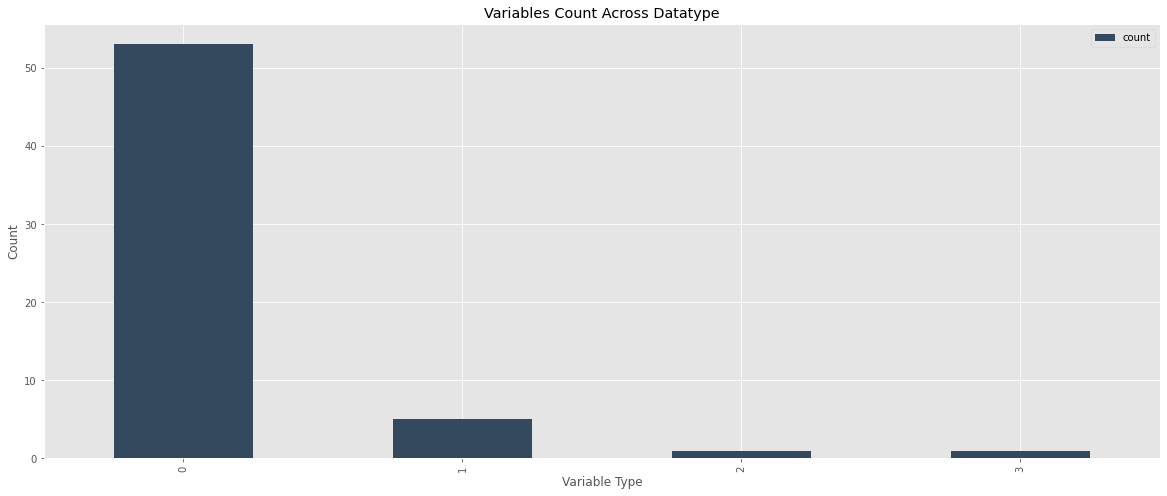

In [80]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
# sns.barplot('variableType', 'count', data=dataTypeDf, ax=ax, color='#34495e')
dataTypeDf.plot(kind='bar', color='#34495e', ax=ax)
ax.set(xlabel='Variable Type', ylabel='Count', title='Variables Count Across Datatype')

### Missing Value Analysis

<AxesSubplot:>

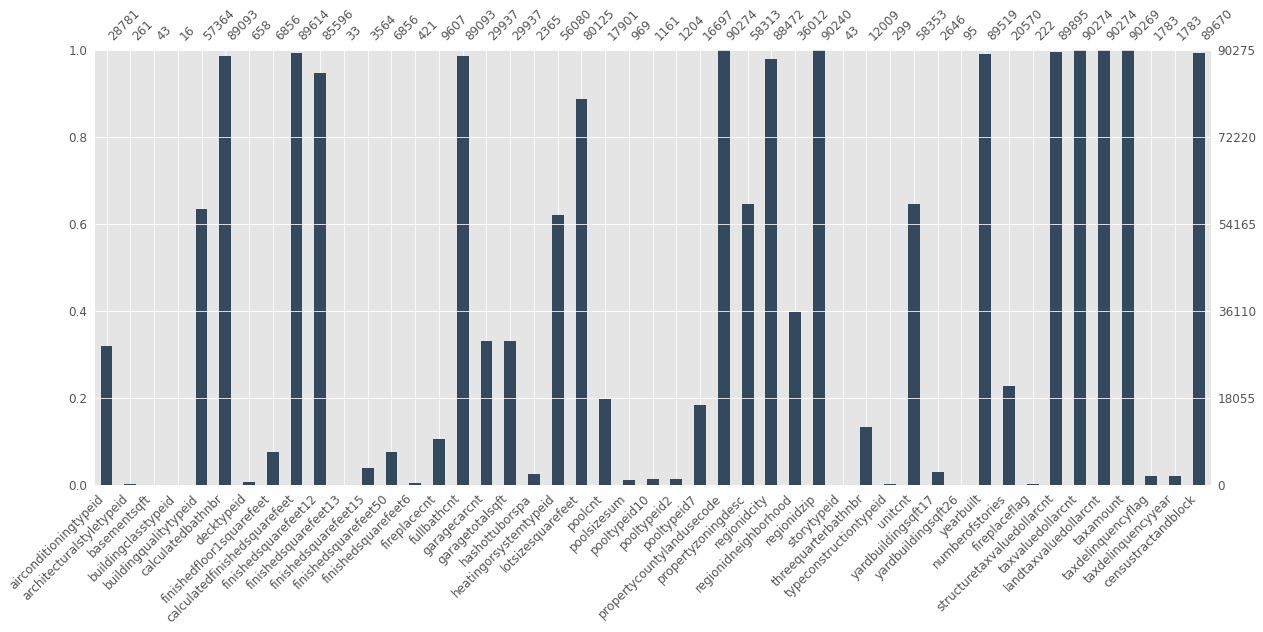

In [31]:
missingValueColumns = merged.columns[merged.isnull().any()].tolist()
msno.bar(merged[missingValueColumns], figsize=(20, 8), color='#34495e', fontsize=12, labels=True)

<AxesSubplot:>

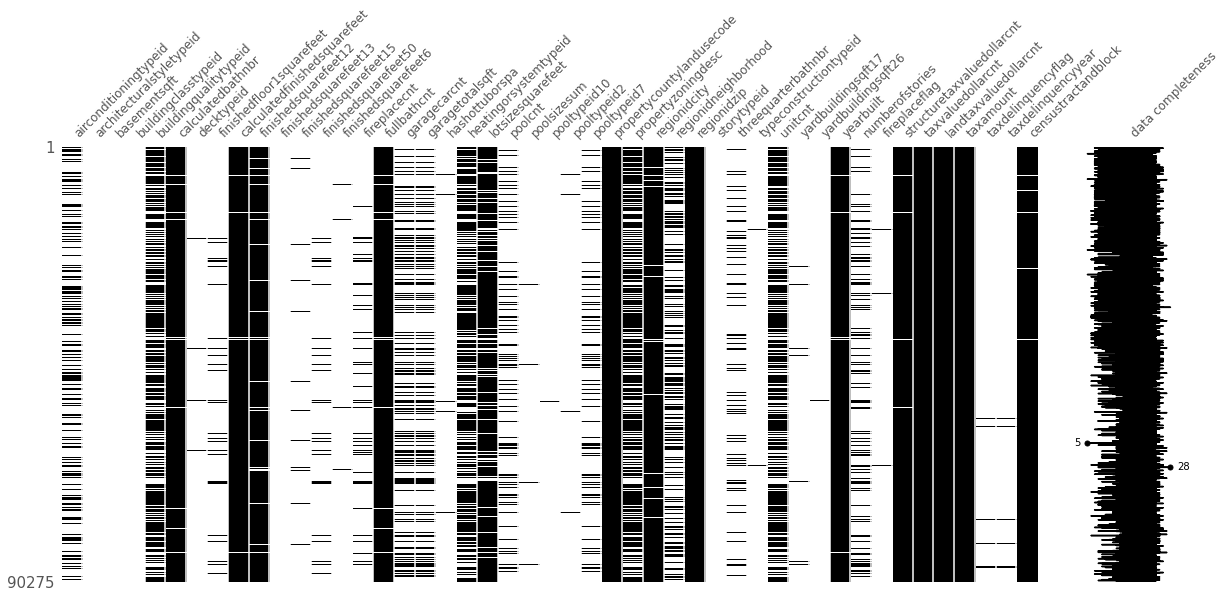

In [35]:
msno.matrix(merged[missingValueColumns], width_ratios=(10, 1), figsize=(20, 8), color=(0, 0, 0), fontsize=12, sparkline=True, labels=True)

<AxesSubplot:>

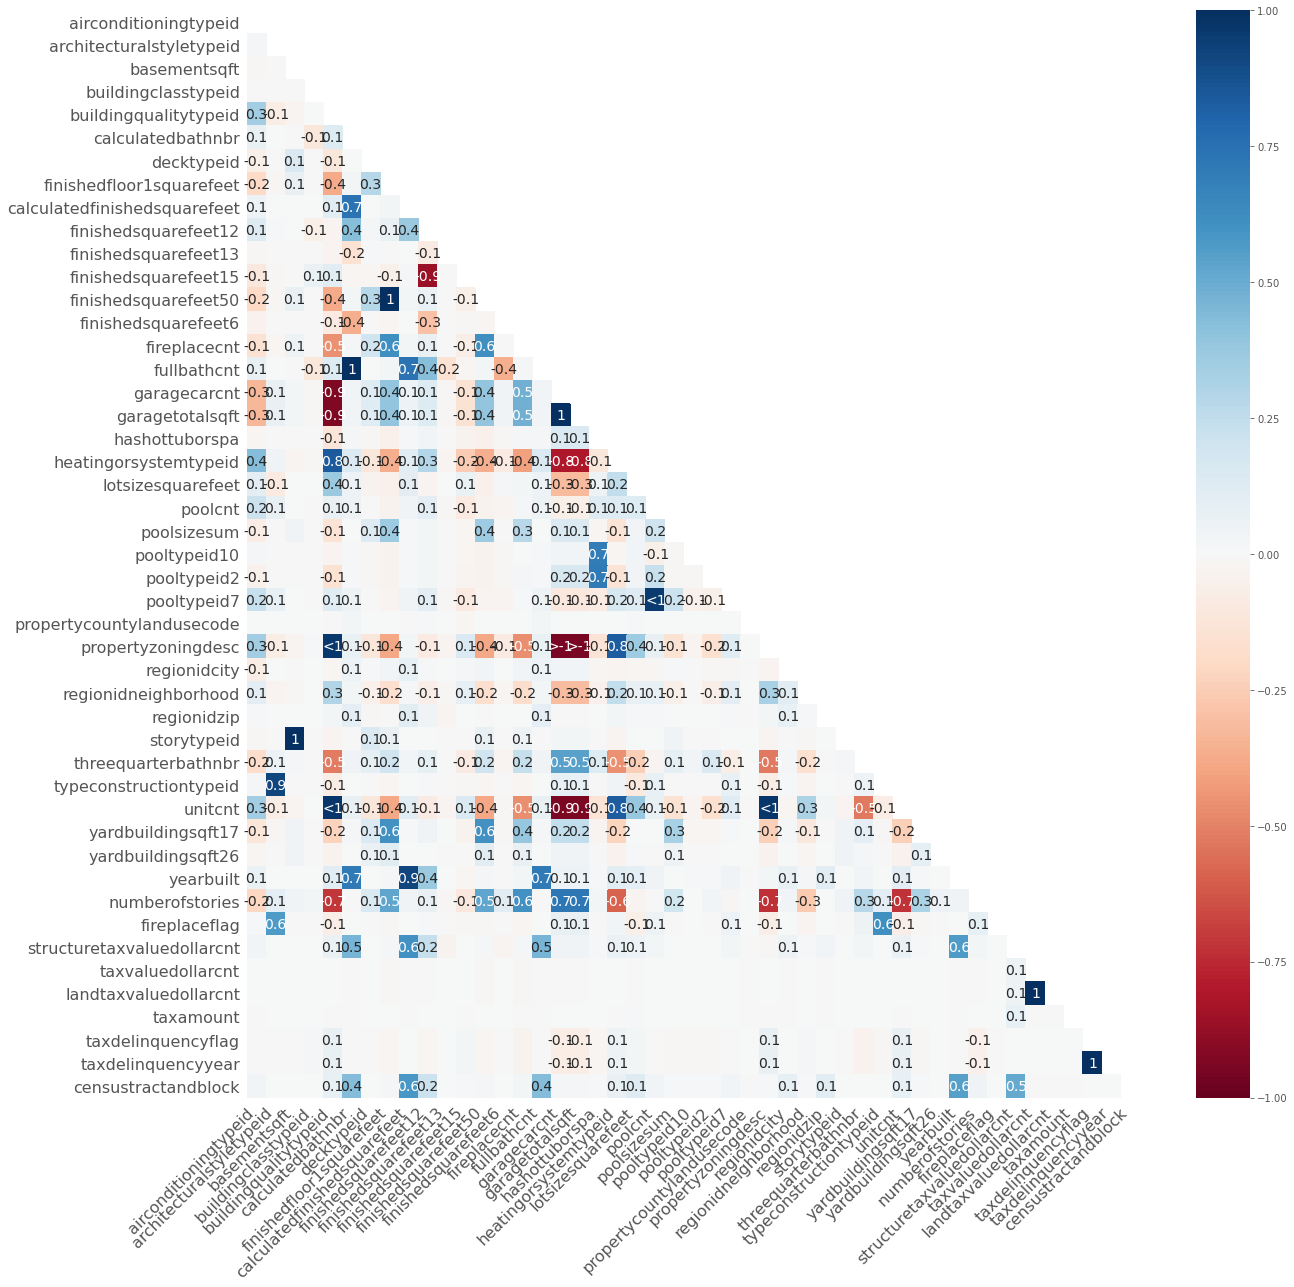

In [36]:
msno.heatmap(merged[missingValueColumns], figsize=(20, 20))

### Top Features Selection

In [37]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

mergedFilterd = merged.fillna(-999)
for f in mergedFilterd.columns:
    if mergedFilterd[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(mergedFilterd[f].values))
        mergedFilterd[f] = lbl.transform(list(mergedFilterd[f].values))

train_x = mergedFilterd.drop(['parcelid', 'transactiondate', 'logerror'], axis=1)
train_y = mergedFilterd['logerror'].values

xgb_params = {
    'eta':0.05, 
    'max_depth':8,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent':1
}
dtrain = xgb.DMatrix(train_x, train_y, feature_names=train_x.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

[11:08:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




<AxesSubplot:xlabel='importance', ylabel='features'>

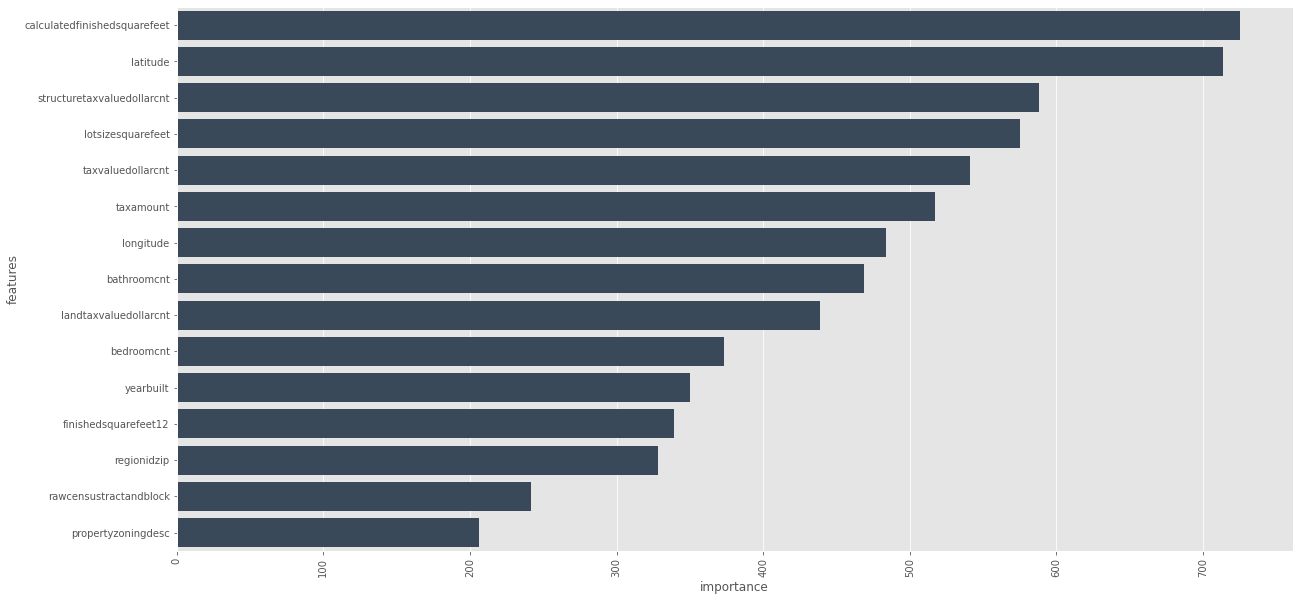

In [38]:
featureImportance = model.get_fscore()
features = pd.DataFrame({
    'features':featureImportance.keys(),
    'importance':featureImportance.values()
})
features.sort_values('importance', ascending=False, inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.xticks(rotation=90)
sns.barplot('importance', 'features', data=features.head(15), ax=ax, orient='h', color='#34495e')

### Correlation Analysis

<AxesSubplot:>

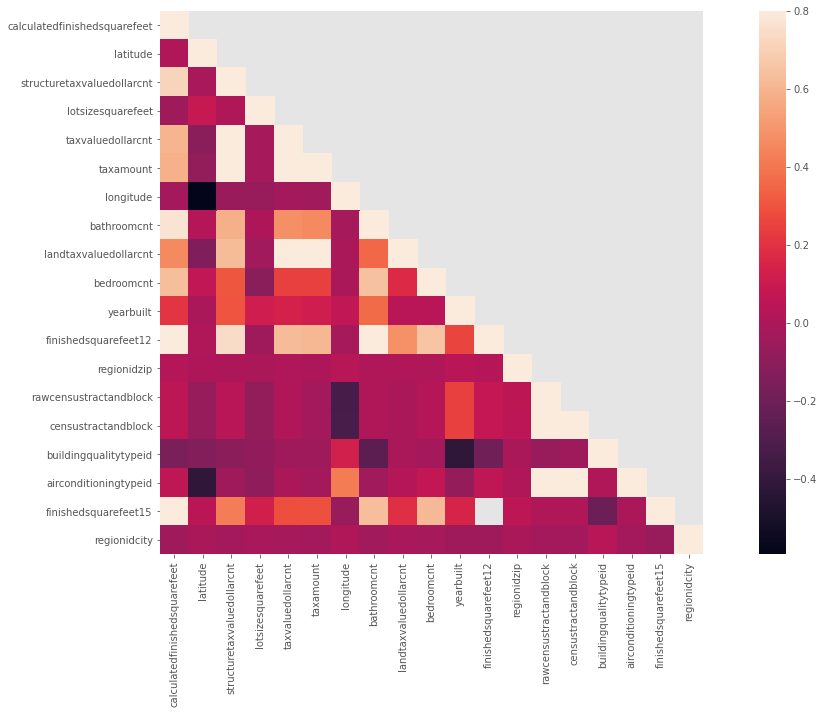

In [51]:
topFeatures = features['features'].tolist()[:20]
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True)

### Multicollinearity Analysis

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif_(x):
    variables = list(x.columns)
    vif = {variable:variance_inflation_factor(exog=x.values, exog_idx=ix) for ix, variable in enumerate(list(x.columns))}
    return vif

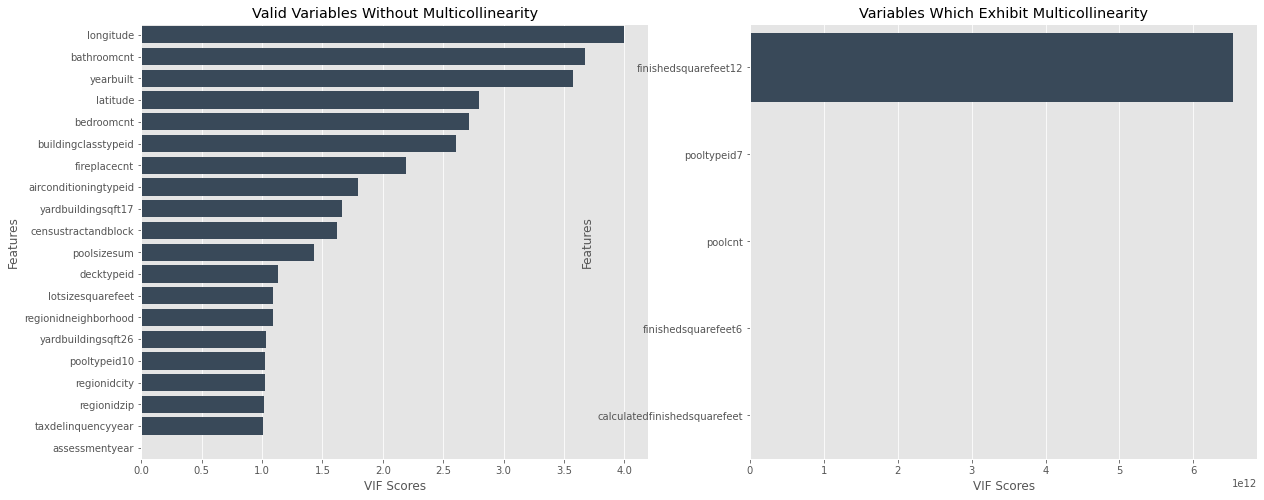

In [57]:
numericalCol = []
for f in merged.columns:
    if merged[f].dtype != 'object' and f not in ['parcelid', 'transactiondate', 'logerror']:
        numericalCol.append(f)
mergedFilterd = merged[numericalCol].fillna(-999)
vifDict = calculate_vif_(mergedFilterd)

vifDf = pd.DataFrame({
    'variables':vifDict.keys(),
    'vifScore':vifDict.values()
})
vifDf.sort_values('vifScore', ascending=False, inplace=True)
validVariables = vifDf[vifDf['vifScore'] <= 5]
variablesWithMC = vifDf[vifDf['vifScore'] > 5]

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 8)
sns.barplot('vifScore', 'variables', data=validVariables, ax=ax1, orient='h', color='#34495e')
sns.barplot('vifScore', 'variables', data=variablesWithMC.head(5), ax=ax2, orient='h', color='#34495e')
ax1.set(xlabel='VIF Scores', ylabel='Features', title='Valid Variables Without Multicollinearity')
ax2.set(xlabel='VIF Scores', ylabel='Features', title='Variables Which Exhibit Multicollinearity')
plt.show()

### Univariate Analysis
종속 변수 logerror은 정규 분포를 따릅니다.

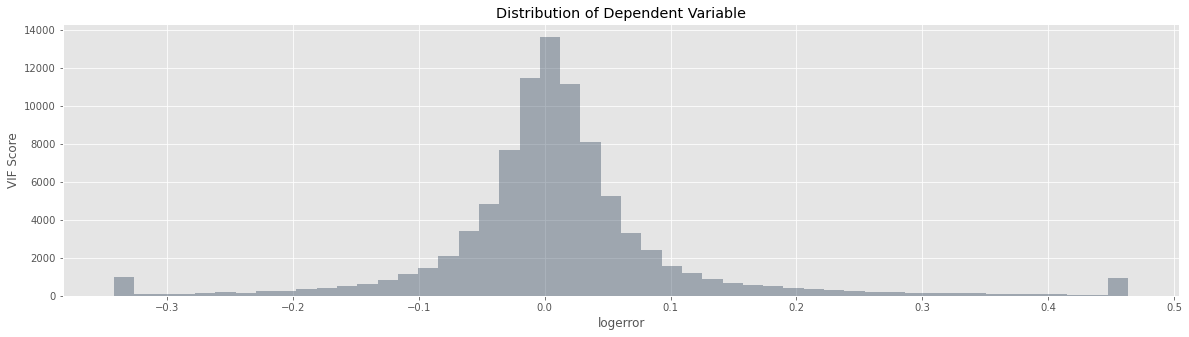

In [62]:
ulimit = np.percentile(merged['logerror'].values, 99)
llimit = np.percentile(merged['logerror'].values, 1)
merged.loc[merged['logerror'] > ulimit, 'logerror'] = ulimit
merged.loc[merged['logerror'] < llimit, 'logerror'] = llimit

fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.distplot(merged['logerror'].values, bins=50, kde=False, color='#34495e', ax=ax)
ax.set(xlabel='logerror', ylabel='VIF Score', title='Distribution of Dependent Variable')
plt.show()

### Bivariate Analysis

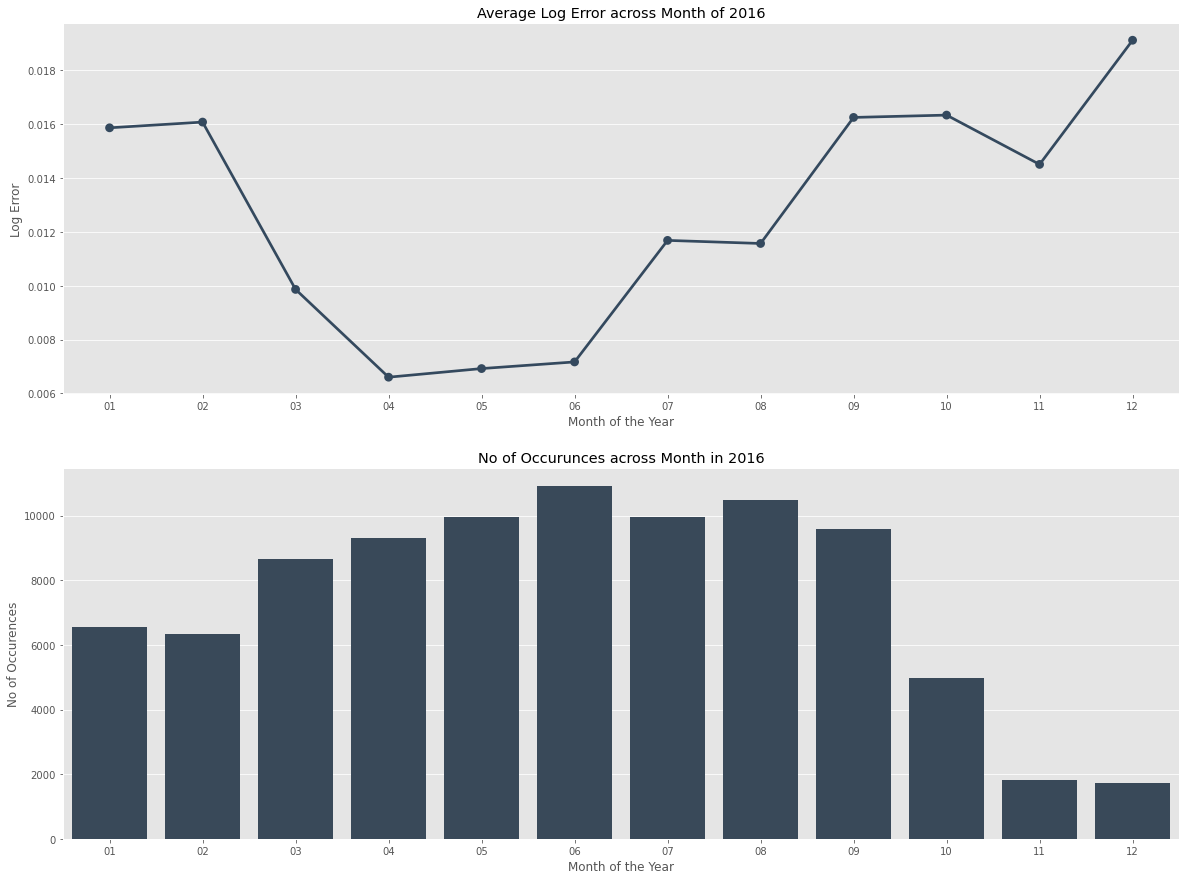

In [69]:
train['year'] = train['transactiondate'].map(lambda x: str(x).split('-')[0])
train['month'] = train['transactiondate'].map(lambda x: str(x).split('-')[1])
train['day'] = train['transactiondate'].map(lambda x: str(x).split('-')[2].split()[0])

traingroupedMonth = train.groupby(['month'])['logerror'].mean().to_frame().reset_index()
traingroupedDay = train.groupby(['day'])['logerror'].mean().to_frame().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=2)
fig.set_size_inches(20, 15)

sns.pointplot('month', 'logerror', data=traingroupedMonth, join=True, ax=ax1, color='#34495e')
ax1.set(xlabel='Month of the Year', ylabel='Log Error',
        title='Average Log Error across Month of 2016', label='big')

sns.countplot(train['month'], ax=ax2, color='#34495e',
              order = sorted(train['month'].unique()))
ax2.set(xlabel='Month of the Year', ylabel='No of Occurences',
        title='No of Occurunces across Month in 2016', label='big')
plt.show()

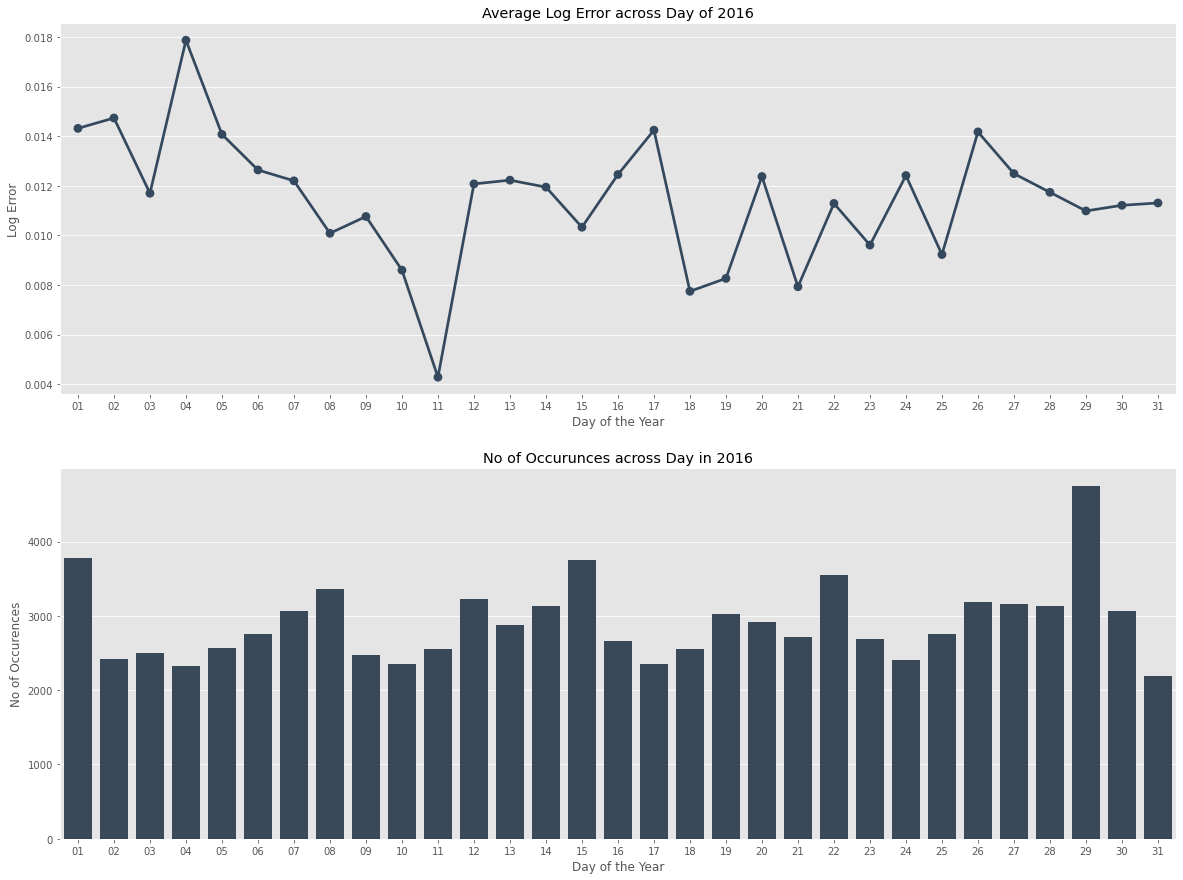

In [71]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
fig.set_size_inches(20, 15)

sns.pointplot('day', 'logerror', data=traingroupedDay, join=True, ax=ax1, color='#34495e')
ax1.set(xlabel='Day of the Year', ylabel='Log Error',
        title='Average Log Error across Day of 2016', label='big')

sns.countplot(train['day'], ax=ax2, color='#34495e',
              order = sorted(train['day'].unique()))
ax2.set(xlabel='Day of the Year', ylabel='No of Occurences',
        title='No of Occurunces across Day in 2016', label='big')
plt.show()

### No of Storey over the Years
1950년 이후에 2~3층 건물을 더 많이 짓기 시작했다는 것이 흥미롭습니다.

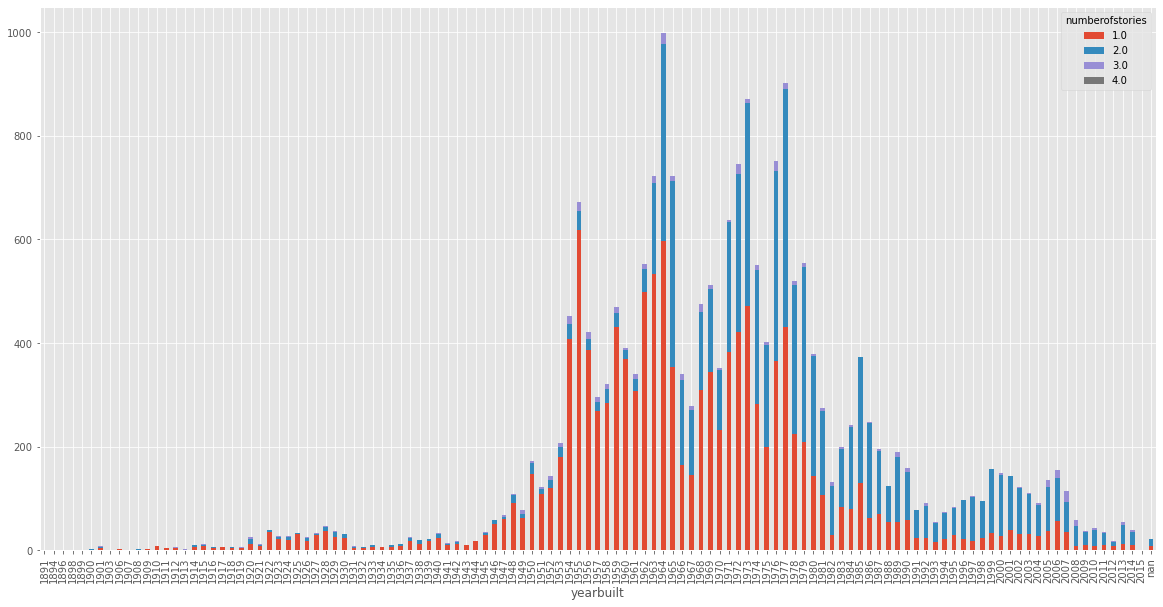

In [78]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)
merged['yearbuilt'] = merged['yearbuilt'].map(lambda x: str(x).split('.')[0])
yearMerged = merged.groupby(['yearbuilt', 'numberofstories'])['parcelid'].count().unstack('numberofstories').fillna(0)
yearMerged.plot(kind='bar', stacked=True, ax=ax1)
plt.show()

In [82]:
cols = ['bathroomcnt', 'bedroomcnt', 'roomcnt', 'numberofstories', 'logerror',
        'calculatedfinishedsquarefeet']
mergedFiltered = merged[cols].dropna()
for col in cols:
    ulimit = np.percentile(mergedFiltered[col].values, 99.5)
    llimit = np.percentile(mergedFiltered[col].values, 0.5)
    mergedFiltered.loc[mergedFiltered[col] > ulimit, col] = ulimit
    mergedFiltered.loc[mergedFiltered[col] < llimit, col] = llimit

### Calculated Finished Square Feet vs. Log Error

<Figure size 576x576 with 0 Axes>

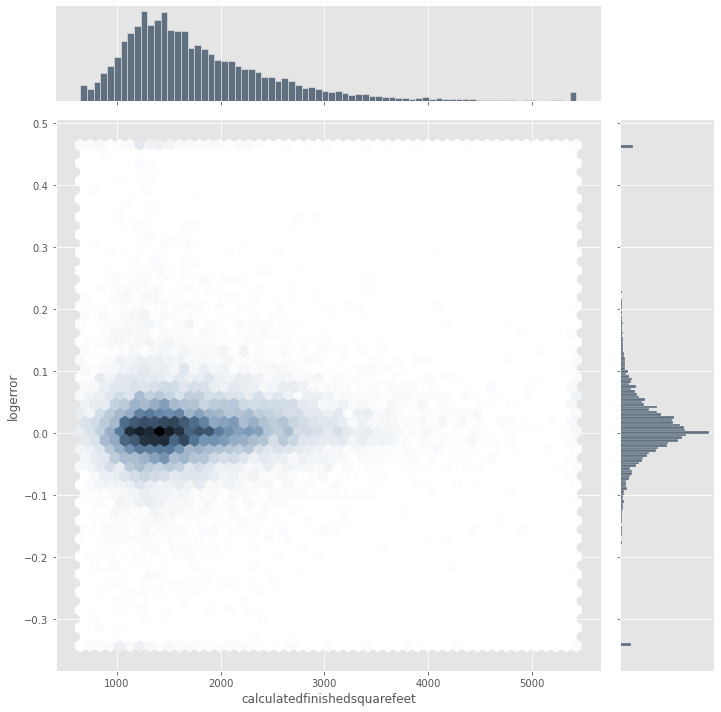

In [83]:
plt.figure(figsize=(8, 8))
sns.jointplot('calculatedfinishedsquarefeet', 'logerror', data=mergedFiltered, size=10, kind='hex', color='#34495e')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated Finished Square Feet', fontsize=12)
plt.show()

### Bedroom Count vs. Log Error

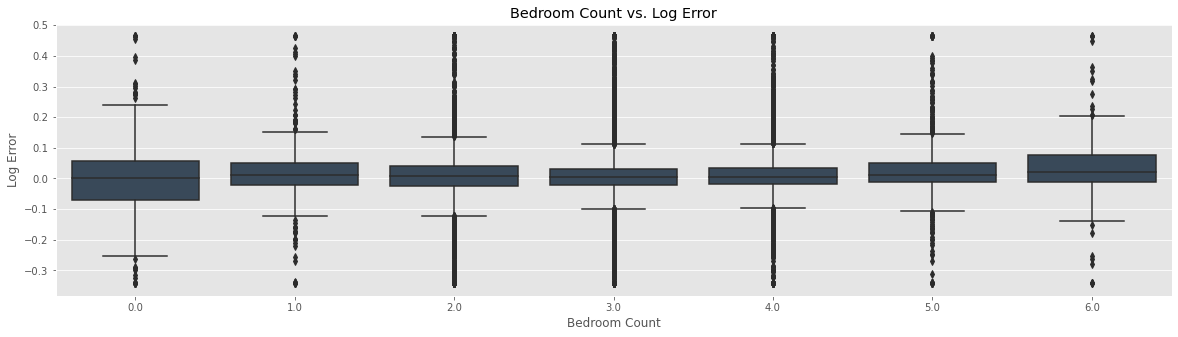

In [84]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.boxplot('bedroomcnt', 'logerror', data=mergedFiltered, ax=ax, color='#34495e')
ax.set(ylabel='Log Error', xlabel='Bedroom Count', title='Bedroom Count vs. Log Error')
plt.show()

### Bathroom Count vs. Log Error

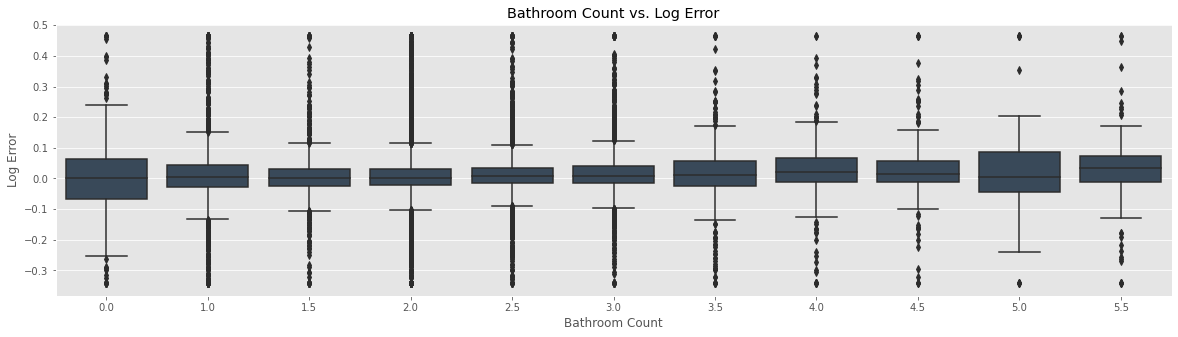

In [85]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.boxplot('bathroomcnt', 'logerror', data=mergedFiltered, ax=ax, color='#34495e')
ax.set(ylabel='Log Error', xlabel='Bathroom Count', title='Bathroom Count vs. Log Error')
plt.show()

### Room Count vs. Log Error

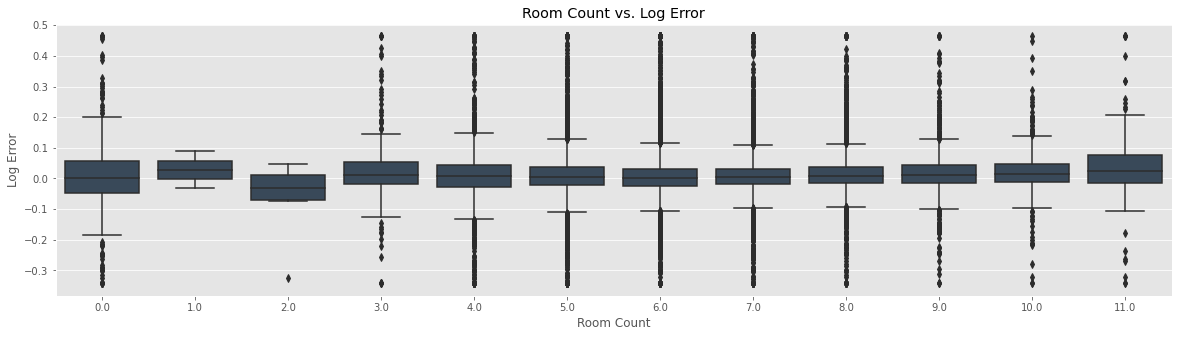

In [86]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.boxplot('roomcnt', 'logerror', data=mergedFiltered, ax=ax, color='#34495e')
ax.set(ylabel='Log Error', xlabel='Room Count', title='Room Count vs. Log Error')
plt.show()

### No of Storeys vs. Log Error

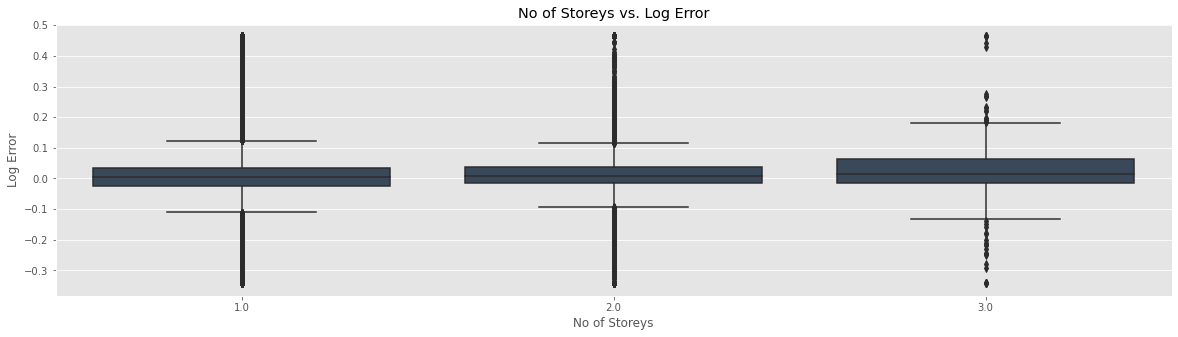

In [87]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.boxplot('numberofstories', 'logerror', data=mergedFiltered, ax=ax, color='#34495e')
ax.set(ylabel='Log Error', xlabel='No of Storeys', title='No of Storeys vs. Log Error')
plt.show()

### Bedroom vs. Bathroom vs. Log Error

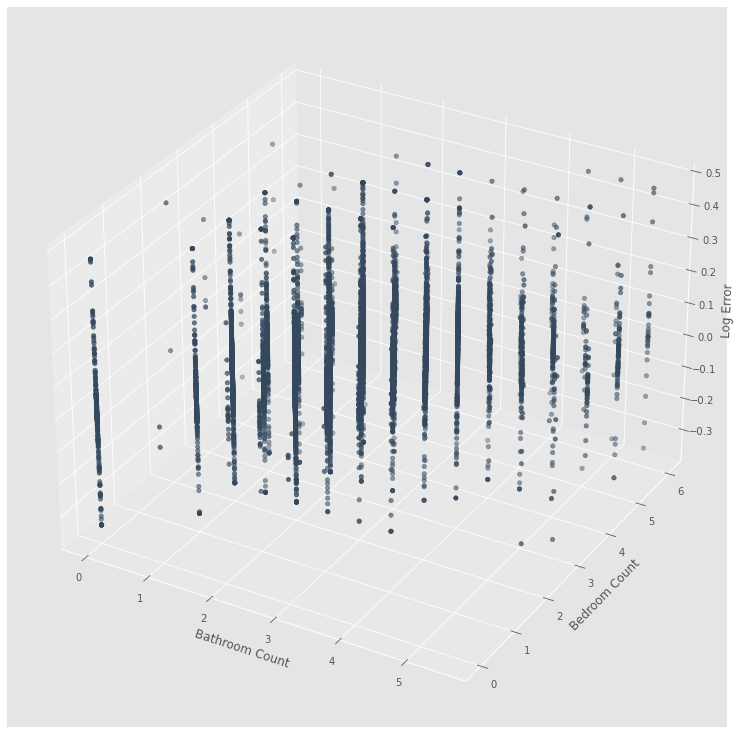

In [89]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
fig = pylab.figure()
fig.set_size_inches(20, 10)
ax = Axes3D(fig)

ax.scatter(mergedFiltered['bathroomcnt'], mergedFiltered['bedroomcnt'], mergedFiltered['logerror'], color='#34495e')
ax.set_xlabel('Bathroom Count')
ax.set_ylabel('Bedroom Count')
ax.set_zlabel('Log Error')
pyplot.show()